In this project, you will create a classification model for dogs breeds, which should work on any photo and provide a classification outcome for it, assign each photo with a breed label.

The training data is in the folder Breeds_classification/Dataset. You can find your own samples (random images of dogs or other animals) for testing the model outside of the provided data.

The data loading and initial preprocessing is provided below. You are free to do further preprocessing if you think it might be useful.
- Be careful if you are running pytorch on a machine with a gpu or a cpu, you might need to do some adjustments for that.

The main requirement of the project is to achieve average accuracy of 90% or higher. More detailed instructions are provided below.


In [2]:
#visualization
import matplotlib.pyplot as plt
#data manipulations
import numpy as np
import pandas as pd
#pytorch
import torchvision
import torchvision.models as models
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
from PIL import Image
#dealing with images from Internet
import requests
from io import BytesIO
# time tracking
from timeit import default_timer as timer


c:\Users\tima0\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Die angegebene Prozedur wurde nicht gefunden'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Load the dataset after some standard transforms. Do not forget to adjust the path to the data.

In [3]:

# transforms for images
image_transform  = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])


# datasets
trainset = torchvision.datasets.ImageFolder("Dataset_DOGS/train", transform = image_transform)
validset = torchvision.datasets.ImageFolder("Dataset_DOGS/valid", transform = image_transform)
testset = torchvision.datasets.ImageFolder("Dataset_DOGS/test", transform = image_transform)

#batches
batch_size = 128

# loaders for data
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

# only use subset of data for initial testing
# Define the fraction of the dataset to use
fraction = 1

print(len(trainset))

# Calculate the number of samples to use
num_samples = int(len(trainset) * fraction)

print(num_samples)


7946
7946


Visualize some images.

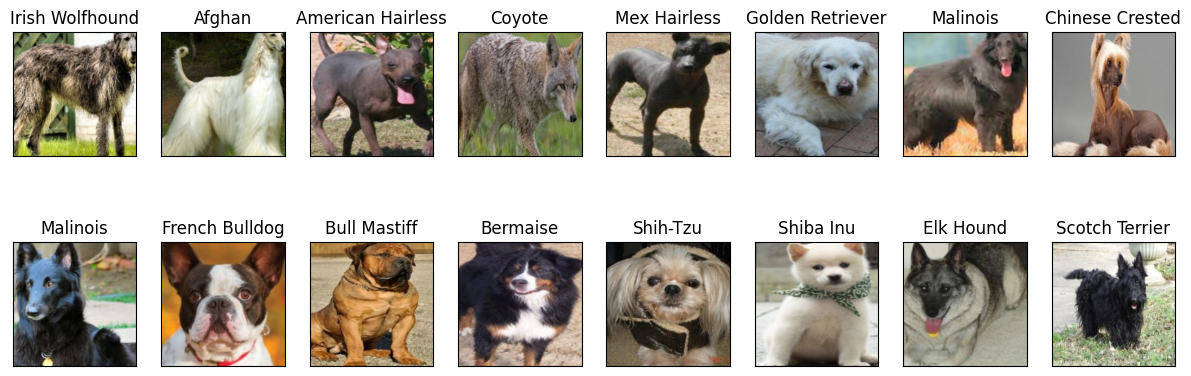

In [4]:
images, labels = next(iter(trainloader))
images, labels = images.numpy() , labels.numpy()


fig = plt.figure(figsize = (15,5))

for i in range(int(batch_size/8)):
    ax = fig.add_subplot(2 , int(batch_size/16) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i] , (1,2,0)) , cmap = 'gray')
    ax.set_title(trainset.classes[labels[i]])

In [5]:
# Single batch
print("number of train batches : ", len(trainloader))
print("number of validation batches : ", len(validloader))
print("Size of test batches : ", len(testloader))

number of train batches :  63
number of validation batches :  6
Size of test batches :  6


In [6]:
print( len(trainset.classes))
print("Classes : ", trainset.classes)

70
Classes :  ['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']


From here on, you are free to run your classification model. 

You can train your own model, and/or use pretrained models. 

Can you achieve accuracy > 90% on all classes? 

The more detailed report you provide on the performance of the models, the more you can improve on your classification. Think of different ways how to visualize and analyze the performance and the accuracy of your model. What is influencing them? How do you measure the performance of your model? Which hyperparameters are critical to improve the performance? How do the performance and accuracy change with the number of training epochs?
Can you apply your model to random images from the internet? 

You can try it on several images from different classes. What happens if you provide an image of other animal? 

In [7]:
# Use ResNet 50 model
model = torchvision.models.resnet50(pretrained = True)

def initModel():
    # Freeze model params
    for param in model.parameters():
        param = param.requires_grad_(False)

    # Add layers
    model.fc = nn.Sequential(
                        nn.Linear(model.fc.in_features, 512),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(512, len(trainset.classes)),
                        nn.LogSoftmax(dim=1))

c:\Users\tima0\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tima0\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.is_available())
print(device)

num_classes = len(trainset.classes)

# Model initialization
initModel()
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 3
best_valid_loss = float('inf')
counter = 0


num_epochs = 20
train_loss_history = []
valid_loss_history = []
train_acc_history = []
valid_acc_history = []


overall_start = timer()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0
    valid_acc = 0
    
    # start timer
    start = timer()

    for ii, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        accuracy = torch.mean((torch.argmax(output, 1) == target).float())
        train_acc += accuracy.item() * data.size(0)

        print(f'Epoch: {epoch+1}\t{100 * (ii + 1) / len(trainloader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.', end='\r')

    train_loss_history.append(train_loss / len(trainloader.dataset))
    train_acc_history.append(train_acc / len(trainloader.dataset))

    
    # Start validation after training epoch
    model.eval()
    with torch.no_grad():
        for data, target in validloader:
            data = data.to(device)
            target = target.to(device)
            
            output = model(data)
            
            loss = criterion(output, target.long())
            valid_loss += loss.item() * data.size(0)
            
            accuracy = torch.mean((torch.argmax(output, 1) == target).float())
            valid_acc += accuracy.item() * data.size(0)


    valid_loss_history.append(valid_loss / len(validloader.dataset))
    valid_acc_history.append(valid_acc / len(validloader.dataset))

    # Check for early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping after {epoch + 1} epochs.")
            break


# Record overall time and print out Report
total_time = timer() - overall_start
print(f'\nTotal time: {total_time:.2f} seconds elapsed. \n')


my_classes = []

classes = [n_class for n_class in range(num_classes)]
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        inputs, targets = data 
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)    
        _, predictions = torch.max(outputs, 1)

        # collect the correct predictions for each class
        for target, prediction in zip(targets, predictions):
            if target == prediction:
                correct_pred[classes[target]] += 1
            total_pred[classes[target]] += 1

for classname, correct_count in correct_pred.items():
    try:
        accuracy = 100 * float(correct_count) / total_pred[classname]

        my_classes.append(accuracy)
    except ZeroDivisionError:
        my_classes.append(np.nan)
        continue

acc =  round(100 * float(sum(correct_pred.values())/sum(total_pred.values())),2)
class_acc = dict(zip(classes,[round(mc,2) for mc in my_classes]))

print(f"Test Accuracy Report")
for key,value in class_acc.items():
    print(f"Class {trainset.classes[key]} has achived {value}% accuracy\n")

print(f"Overall accuracy: {acc}%")

True
cuda
Early stopping after 7 epochs.78 seconds elapsed in epoch.

Total time: 156.72 seconds elapsed. 

Test Accuracy Report
Class Afghan has achived 100.0% accuracy

Class African Wild Dog has achived 100.0% accuracy

Class Airedale has achived 100.0% accuracy

Class American Hairless has achived 90.0% accuracy

Class American Spaniel has achived 70.0% accuracy

Class Basenji has achived 100.0% accuracy

Class Basset has achived 100.0% accuracy

Class Beagle has achived 100.0% accuracy

Class Bearded Collie has achived 90.0% accuracy

Class Bermaise has achived 100.0% accuracy

Class Bichon Frise has achived 100.0% accuracy

Class Blenheim has achived 90.0% accuracy

Class Bloodhound has achived 100.0% accuracy

Class Bluetick has achived 100.0% accuracy

Class Border Collie has achived 100.0% accuracy

Class Borzoi has achived 100.0% accuracy

Class Boston Terrier has achived 0.0% accuracy

Class Boxer has achived 100.0% accuracy

Class Bull Mastiff has achived 100.0% accuracy

C

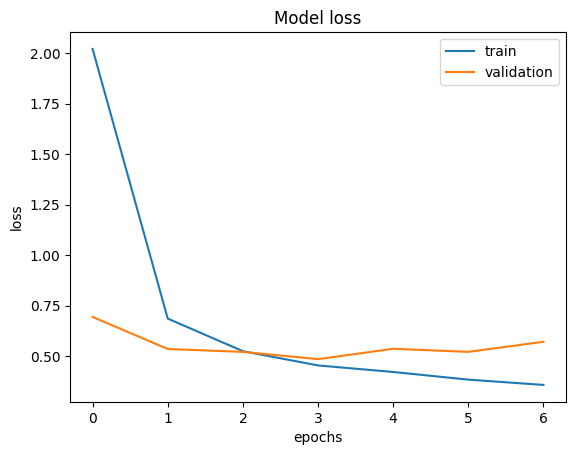

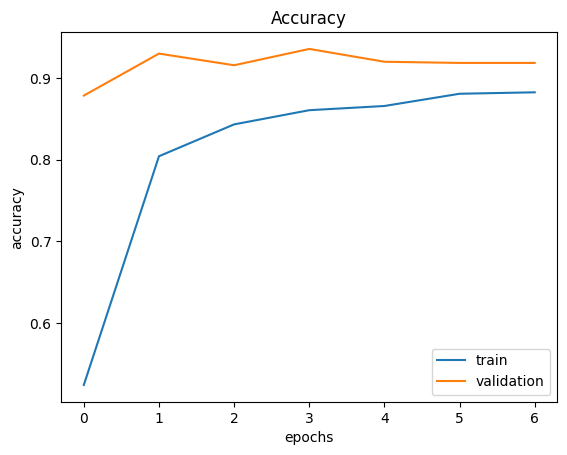

In [9]:
plt.figure(1)
plt.title("Model loss")
plt.plot(train_loss_history, label = "train")
plt.plot(valid_loss_history, label = "validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure(2)
plt.title("Accuracy")
plt.plot(train_acc_history, label = "train")
plt.plot(valid_acc_history, label = "validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [10]:
# save model to disk
torch.save(model.state_dict(), 'saved_models/breeds-classification-model.pth')

RuntimeError: Parent directory saved_models does not exist.

In [112]:
# load model from file

# model = torchvision.models.resnet18(pretrained = True)
# initModel()
# 
# model_path = 'saved_models/breeds-classification-model.pth'
# 
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     model.load_state_dict(torch.load(model_path), map_location=torch.device('cuda'))
# else:
#     device = torch.device("cpu")
#     model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# 
# # set the model in evaluation mode after loading the weights
# model.eval()

In [1]:
# Load the image from the internet
# Husky: https://allbigdogbreeds.com/wp-content/uploads/2015/05/Siberian-Husky-1.jpg
# Newfoundland: https://betterpet.com/wp-content/uploads/2023/02/brown-newfoundland-dog.jpg
# Doberman: https://www.omlet.us/images/cache/1024/682/Dog-Doberman_Pinscher-A_male_Doberman_Pinscher_showing_off_his_stubby_tail_and_muscular_body.jpg
# Turtle: https://hddesktopwallpapers.in/wp-content/uploads/2015/09/turtle-wallpaper-hd.jpg
# Giraffe: https://www.thoughtco.com/thmb/twPFYaGYCgKdVmZ28rBPmXGU8kY=/2121x0/filters:no_upscale():max_bytes(150000):strip_icc()/GettyImages-872346454-5c37b2dec9e77c000132a628.jpg

url = "https://www.omlet.us/images/cache/1024/682/Dog-Doberman_Pinscher-A_male_Doberman_Pinscher_showing_off_his_stubby_tail_and_muscular_body.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Preprocess the image
img = image_transform(img)
img = img.unsqueeze(0).to(device)

# Make a prediction
model.eval()
with torch.no_grad():
    output = model(img)
    _, predicted_class = torch.max(output, 1)

# Print the predicted class
print(f"Predicted Class: {predicted_class.item()}")
print(trainset.classes[predicted_class.item()])


NameError: name 'requests' is not defined